In [1]:
import tensorflow as tf
import librosa

print(f"TensorFlow Version: {tf.__version__}")
print(f"Librosa Version: {librosa.__version__}")

TensorFlow Version: 2.12.0
Librosa Version: 0.10.1


Cell 1: Imports
This cell imports all the main libraries we'll need for this phase

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
import pickle

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.12.0


Cell 2: Load Image Paths and Prepare Labels
This cell will get a list of all our spectrogram image paths. More importantly, it will convert our text labels (the species names) into a binary format ([0, 1, 0, 0, ...]) that the neural network can understand.

In [3]:
SPECTROGRAM_DIR = '../data/birds/spectrograms/'

files = os.listdir(SPECTROGRAM_DIR)
filepaths = [os.path.join(SPECTROGRAM_DIR, f) for f in files if f.endswith('.png')]
labels = [f.split('_')[0] for f in files if f.endswith('.png')]

labels_series = pd.Series(labels)
class_counts = labels_series.value_counts()

# Filter for classes with at least 5 samples for a robust split
classes_to_keep = class_counts[class_counts >= 5].index.tolist()

filtered_indices = labels_series.isin(classes_to_keep)
filepaths = np.array(filepaths)[filtered_indices].tolist()
labels = labels_series[filtered_indices].tolist()

classes = sorted(list(set(labels)))
print(f"Filtered down to {len(filepaths)} spectrograms belonging to {len(classes)} classes (with >= 5 samples each).")

mlb = MultiLabelBinarizer(classes=classes)
y = mlb.fit_transform([[label] for label in labels])

print("\nShape of our data (X):", len(filepaths))
print("Shape of our labels (y):", y.shape)

Filtered down to 24459 spectrograms belonging to 182 classes (with >= 5 samples each).

Shape of our data (X): 24459
Shape of our labels (y): (24459, 182)


Cell 3: Split the Data
This cell splits your file paths and labels into training (70%), validation (15%), and test (15%) sets. We use stratify=y to ensure that all three sets have a proportional representation of each bird species.

In [4]:
# First, split into a training+validation set (80%) and a test set (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    filepaths, 
    y, 
    test_size=0.20, 
    random_state=42, 
    stratify=y
)

# Next, split the training+validation set into a final training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, 
    y_train_val, 
    test_size=0.20, 
    random_state=42, 
    stratify=y_train_val
)

print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

Training set size: 15653
Validation set size: 3914
Test set size: 4892


Step 3: Create a Data Pipeline
This step involves two parts:

A function to load and preprocess a single image.

Using that function to build a tf.data.Dataset for each of our sets (train, validation, test)

Cell 4: Preprocessing Function
This function takes a file path, reads the PNG image, resizes it to a standard size (e.g., 128x128), and normalizes the pixel values to be between 0 and 1.

In [5]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

IMG_SIZE = 128
BATCH_SIZE = 32

def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.io.decode_png(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32)
    image = preprocess_input(image) 
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=len(X_train)).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

print("Training, validation, and test datasets are ready.")

Training, validation, and test datasets are ready.


*Cell 5: Build the Datasets*



Now we'll use the function from the previous cell to build our data pipelines. We'll shuffle and batch the training data for effective learning and batch the validation/test data for efficient evaluation

In [6]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras import layers, models

NUM_CLASSES = len(mlb.classes_)

base_model = EfficientNetV2B0(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Function  (None, 4, 4, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 182)               233142    
                                                                 
Total params: 6,152,454
Trainable params: 233,142
Non-trainable params: 5,919,312
_________________________________________________________________




Step 4: Build the CNN Model Architecture
We will use the Keras Sequential API from TensorFlow to build our model. Think of this as stacking layers on top of each other.

Conv2D and MaxPooling2D: These are the core layers for image processing. They work together to find patterns like edges, textures, and shapes in the spectrograms.

Flatten: This layer converts the 2D image data into a flat 1D list so it can be processed by the final classification layers.

Dense: These are the standard, fully-connected layers that perform the final classification.

Dropout: This is a regularization technique that helps prevent the model from "memorizing" the training data (overfitting).

Cell 6: Define the Model


In [7]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras import layers, models

# Get the number of classes from our label binarizer
NUM_CLASSES = len(mlb.classes_)

# 1. Load the pre-trained model (base model)
# We will not include the final classification layer (include_top=False)
base_model = EfficientNetV2B0(
    include_top=False,
    weights='imagenet', # Use weights pre-trained on ImageNet
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# 2. Freeze the base model
# This prevents the learned weights of the base model from changing during training
base_model.trainable = False

# 3. Add our new classification layers on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(), # A layer to reduce the feature dimensions
    layers.Dropout(0.5), # Regularization to prevent overfitting
    layers.Dense(NUM_CLASSES, activation='sigmoid') # Our final output layer
])

# Print a summary of the new model's architecture
model.summary() 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Function  (None, 4, 4, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 182)               233142    
                                                                 
Total params: 6,152,454
Trainable params: 233,142
Non-trainable params: 5,919,312
_________________________________________________________________


Step 5: Compile the Model
Compiling the model configures it for training. We need to specify three key things:

Optimizer: The algorithm that updates the model's weights. Adam is a robust and popular choice.

Loss Function: How the model measures its error. For multi-label classification (where multiple birds can be present), binary_crossentropy is the correct choice.

Metrics: What we monitor during training. We'll start with accuracy.

Cell 7: Compile the Model

In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully.")

Model compiled successfully.


Step 6: Train the Model
We will now "fit" the model to our data. This is the process where the model learns the patterns in the spectrograms. We will call the model.fit() function, providing it with our training and validation datasets.

Epoch: One complete pass through the entire training dataset. We'll start with 10 epochs.

This step is computationally intensive and will take some time. You will see live output as the model trains, showing you its accuracy and loss on both the training and validation data for each epoch.

Cell 8: Start Training

In [9]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]


In [10]:
EPOCHS = 100

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

print("\nModel training complete!")

Epoch 1/100
490/490 [==============================] - 153s 291ms/step - loss: 0.1677 - accuracy: 0.0067 - val_loss: 0.0457 - val_accuracy: 0.0164
Epoch 2/100
490/490 [==============================] - 203s 403ms/step - loss: 0.0427 - accuracy: 0.0234 - val_loss: 0.0343 - val_accuracy: 0.0723
Epoch 3/100
490/490 [==============================] - 213s 422ms/step - loss: 0.0353 - accuracy: 0.0507 - val_loss: 0.0318 - val_accuracy: 0.1004
Epoch 4/100
490/490 [==============================] - 232s 460ms/step - loss: 0.0329 - accuracy: 0.0698 - val_loss: 0.0307 - val_accuracy: 0.1242
Epoch 5/100
490/490 [==============================] - 242s 482ms/step - loss: 0.0317 - accuracy: 0.0880 - val_loss: 0.0300 - val_accuracy: 0.1423
Epoch 6/100
490/490 [==============================] - 259s 514ms/step - loss: 0.0308 - accuracy: 0.1089 - val_loss: 0.0294 - val_accuracy: 0.1551
Epoch 7/100
490/490 [==============================] - 272s 541ms/step - loss: 0.0301 - accuracy: 0.1241 - val_loss: 0

KeyboardInterrupt: 

Cell 9: Visualize Training History
Plotting the training and validation accuracy/loss helps us understand how the model learned over time

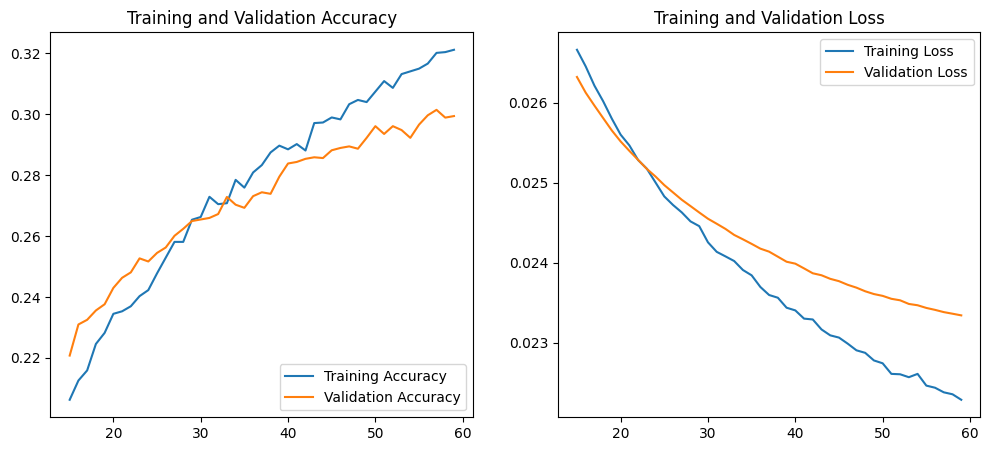

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Cell 10: Evaluate on the Test Set
This is the true test of our model's performance on data it has never seen before.

In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"\nTest Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")    

153/153 [==============================] - 75s 486ms/step - loss: 0.0232 - accuracy: 0.3187

Test Loss: 0.02321132831275463
Test Accuracy: 0.31868356466293335


Cell 11: Get Detailed Metrics
Accuracy alone can be misleading. A classification_report gives us precision, recall, and F1-score for each bird species, which is much more insightful.

Precision: Of all the times the model predicted a certain bird, how often was it correct?

Recall: Of all the actual instances of a certain bird, how many did the model correctly identify?

In [ ]:
y_pred_probs = model.predict(test_ds)
y_pred = (y_pred_probs > 0.5).astype(int)

report = classification_report(y_test, y_pred, target_names=mlb.classes_, zero_division=0)
print(report)

153/153 [==============================] - 62s 407ms/step
              precision    recall  f1-score   support

      asbfly       0.00      0.00      0.00        21
     ashdro1       0.00      0.00      0.00        22
     ashpri1       0.00      0.00      0.00        19
     ashwoo2       0.00      0.00      0.00         9
     asikoe2       1.00      0.02      0.04        55
     asiope1       0.00      0.00      0.00         1
     aspfly1       0.00      0.00      0.00         5
     aspswi1       0.00      0.00      0.00         5
     barfly1       0.00      0.00      0.00         4
      barswa       1.00      0.02      0.04       100
      bcnher       0.82      0.09      0.16       100
     bkcbul1       0.00      0.00      0.00         5
     bkrfla1       0.00      0.00      0.00         6
     bkskit1       1.00      0.06      0.11        54
      bkwsti       0.90      0.09      0.16       100
     bladro1       0.00      0.00      0.00        25
     blaeag1       0.00

c:\Projects\Final_year_project\species_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Projects\Final_year_project\species_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Cell 12: Save the Model and Labels
Finally, let's save our trained model and the label encoder (MultiLabelBinarizer). We will need both of these files for our Streamlit application.

In [ ]:
os.makedirs('../models', exist_ok=True)
model.save('../models/bird_model.h5')

with open('../models/mlb.pkl', 'wb') as f:
    pickle.dump(mlb, f)

print("\nFinal model and label encoder saved successfully.") 


Model and label encoder saved successfully in the 'models' folder.


In [6]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]


In [3]:
import tensorflow as tf
from tensorflow.python.platform import build_info

print("TF Version:", tf.__version__)
print("CUDA Version:", build_info.build_info['cuda_version'])
print("cuDNN Version:", build_info.build_info['cudnn_version'])

TF Version: 2.12.0


KeyError: 'cuda_version'